In [13]:
import pandas as pd
import pynhd as nhd
from pynhd import NLDI, NHDPlusHR, WaterData


In [123]:

station_id = "08290000"

# Initialize the NLDI retrieval tool
nldi = NLDI()

# Find the basin upstream of the station
basin = nldi.get_basins(station_id)

# Find the main flow line
main_flow = nldi.navigate_byid(
    fsource="nwissite",
    fid=f"USGS-{station_id}",
    navigation="upstreamMain",
    source="flowlines",
    distance=1000)

tributary_flow = nldi.navigate_byid(
    fsource="nwissite",
    fid=f"USGS-{station_id}",
    navigation="upstreamTributaries",
    source="flowlines",
    distance=1000)

all_stations = nldi.navigate_byid(
    fsource="nwissite",
    fid=f"USGS-{station_id}",
    navigation="upstreamTributaries",
    source="nwissite",
    distance=1000)

pour_points = nldi.navigate_byid(
    fsource="nwissite",
    fid=f"USGS-{station_id}",
    navigation="upstreamTributaries",
    source="huc12pp",
    distance=1000)

nmwdi = nldi.navigate_byid(
    fsource="nwissite",
    fid=f"USGS-{station_id}",
    navigation="upstreamTributaries",
    source="nmwdi-st",
    distance=1000)

In [124]:
## Combine data
main_flow['type'] = 'main'
tributary_flow['type'] = 'tributary'
all_stations['type'] = 'station'
pour_points['type'] = 'pourpoint'
nmwdi['type'] = 'nmwdi'
basin['type'] = 'basin'

basin['description'] = 'Basin boundary.'
main_flow['description'] = f'The mainflow river upstream of USGS-{station_id}'
tributary_flow['description'] = f'Tributary river flows upstream of USGS-{station_id}'
all_stations['description'] = " "
pour_points['description'] = f'HUC12 Pour Point'
nmwdi['description'] = 'New Mexico Water Data Initiative Site <br>Water quality well.'

for i in all_stations.index:
    all_stations.loc[i, 'description'] = f'{all_stations.loc[i, "identifier"]} <br>Name: {all_stations.loc[i, "name"]}'

keep_columns = ['geometry', 'type', 'description']

all_data = pd.concat([basin[keep_columns], 
                      main_flow[keep_columns],
                      tributary_flow[keep_columns],
                      all_stations[keep_columns],
                      pour_points[keep_columns],
                      nmwdi[keep_columns]
                      ]).reset_index(drop=True)


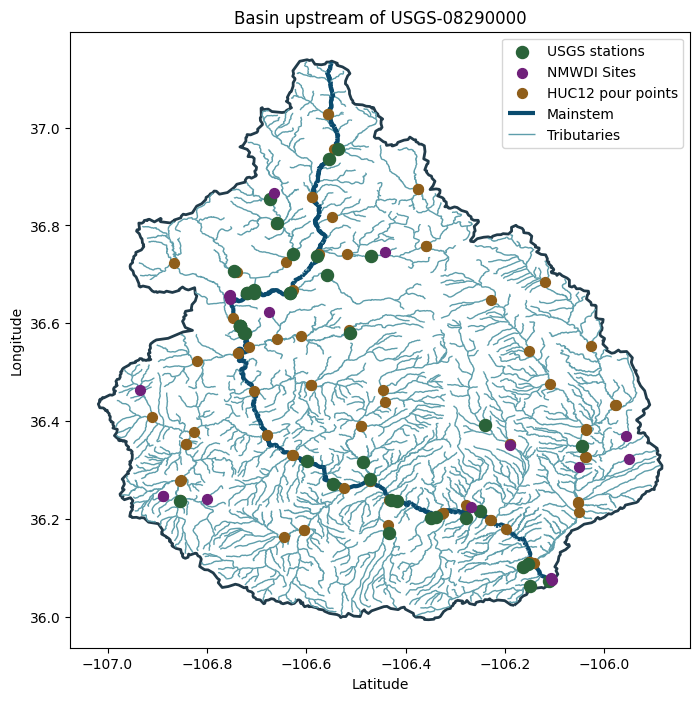

In [128]:
## Visualize basin features

# Line colors
basin_color, mainstem_color, tributary_color = ['#213b4a', '#0a4b6e', '#5e9eab']
 
# Point colors
usgs_color, nmwdi_color, pourpoint_color = ['#2a6339' , '#70207a', '#8f5e1a']

# Plot all features
ax = basin.plot(facecolor="none", edgecolor=basin_color, lw = 2, figsize=(8, 8))
all_stations.plot(ax=ax, label="USGS stations", marker="o", markersize=75, zorder=4, color= usgs_color)
nmwdi.plot(ax=ax, label = 'NMWDI Sites', marker = "o", markersize = 50, color = nmwdi_color, zorder = 5)
pour_points.plot(ax=ax, label="HUC12 pour points", marker="o", markersize=50, color=pourpoint_color, zorder=3)
main_flow.plot(ax=ax, lw=3, color=mainstem_color, zorder=2, label="Mainstem")
tributary_flow.plot(ax=ax, lw=1, zorder=1, color = tributary_color, label="Tributaries")
ax.legend(loc="best")
ax.set_aspect("auto")
ax.figure.set_dpi(100)
ax.set_title(f'Basin upstream of USGS-{station_id}')
ax.set_ylabel('Longitude')
ax.set_xlabel('Latitude')
ax.figure.savefig("static_map.png", bbox_inches="tight", dpi=100)

In [127]:
all_data.to_csv('data/basin_data.csv', sep = ',')